# Chapter 05 Trading Edge

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import pathlib
import arcticdb as adb
from arcticdb import LibraryOptions
from dateutil.relativedelta import relativedelta
import requests 
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

In [2]:
def initialise_adb_library_local(uri_path, library_name):
    uri = f"lmdb://{uri_path}" # this will set up the storage using the local file system
    ac = adb.Arctic(uri)
    library = ac.get_library(library_name, create_if_missing=True,)# library_options=LibraryOptions(dynamic_schema=True))
    return library

def adb_concat_single_column(library, symbols, column_name):
    symbols_list = [symbol for symbol in symbols if symbol in library.list_symbols()]
    comp_list_from_adb = [
        library.read(symbol, columns=[column_name]).data.rename(columns={column_name: symbol})
        for symbol in symbols_list
    ]
    return pd.concat(comp_list_from_adb, axis=1)

#### Arctic Database Initialization and Cross-Universe Data Retrieval

**Objective:** Implement helper functions to initialize local Arctic database connections and efficiently retrieve specified columns across multiple tickers for universe-wide analysis.

**Steps:**
- `initialise_adb_library_local()`: Construct LMDB URI path from directory and library name, create Arctic connection, and get or create named library with dynamic schema support.
- `adb_concat_single_column()`: Filter symbol list to only include those present in the library to avoid missing-data errors; read specified column for each valid symbol and rename to ticker name for clarity; concatenate all series horizontally into wide-format DataFrame.
- Both functions enable efficient data pipelining: initialize once, then retrieve any column(s) across the full S&P 500 universe in a single call.

**Result:** Reusable database interface functions enabling rapid retrieval of universe-wide time series (e.g., all "Close" prices or regime scores across 500+ stocks) for cross-sectional and time-series analysis.

In [3]:
library_SP500 = initialise_adb_library_local('data', 'SP500')
print('S&P 500: ',len(library_SP500.list_symbols()[:]), end =', ')
px_df = adb_concat_single_column(library_SP500, library_SP500.list_symbols(), 'Close')
px_df.shape

S&P 500:  516, 

(2756, 516)

#### S&P 500 Universe Data Loading

**Objective:** Initialize Arctic database connection and retrieve closing prices for entire S&P 500 universe into wide-format DataFrame.

**Steps:**
- Call `initialise_adb_library_local()` with 'data' directory and 'SP500' library name to establish LMDB connection and get library reference.
- Print symbol count to confirm database connectivity and verify number of available tickers.
- Call `adb_concat_single_column()` to retrieve 'Close' column for all symbols in library; concatenates horizontally with tickers as columns and dates as rows.
- Display DataFrame shape showing (number of dates × number of tickers) to confirm successful data retrieval.

**Result:** Wide-format DataFrame `px_df` containing daily closing prices for 500+ S&P 500 constituents; ready for cross-sectional analysis, regime detection, and pairs discovery.

In [4]:
# ticker = '^GSPC'
ticker = 'GE'
ticker_raw_data = library_SP500.read(ticker).data
ticker_raw_data.shape

(2756, 104)

In [5]:
def expectancy(win_rate,avg_win,avg_loss):    
    return win_rate * avg_win + (1-win_rate) * avg_loss 
     
def geometric_expectancy(win_rate,avg_win,avg_loss):    
    return (1 + avg_win) ** win_rate * (1 + avg_loss) ** (1 - win_rate) - 1  
     
def kelly(win_rate,avg_win,avg_loss):  
    return win_rate / np.abs(avg_loss) - (1-win_rate) / avg_win 

#### Trading Edge Metrics: Expectancy and Position Sizing Calculations

**Objective:** Define mathematical functions to quantify trading edge through expectancy calculations and determine optimal position sizing using the Kelly Criterion.

**Steps:**
- `expectancy()`: Calculate arithmetic expectancy as weighted average of wins and losses: (win_rate × avg_win) + (1 - win_rate) × avg_loss; represents expected profit/loss per trade in linear terms.
- `geometric_expectancy()`: Calculate geometric expectancy using compound growth formula: (1 + avg_win)^win_rate × (1 + avg_loss)^(1-win_rate) - 1; accounts for compounding effects and path dependency in portfolio growth.
- `kelly()`: Calculate Kelly Criterion for optimal position sizing: win_rate / |avg_loss| - (1 - win_rate) / avg_win; determines fraction of capital to risk that maximizes long-term geometric growth while avoiding ruin.

**Result:** Three core functions quantifying strategy edge and optimal leverage; positive expectancy indicates profitable strategy; Kelly fraction provides theoretically optimal bet size to maximize compound returns.

<Axes: title={'center': 'GE: Cumulative Relative Returns, L/S Returns, Score Rel, L/S Score'}, xlabel='Date'>

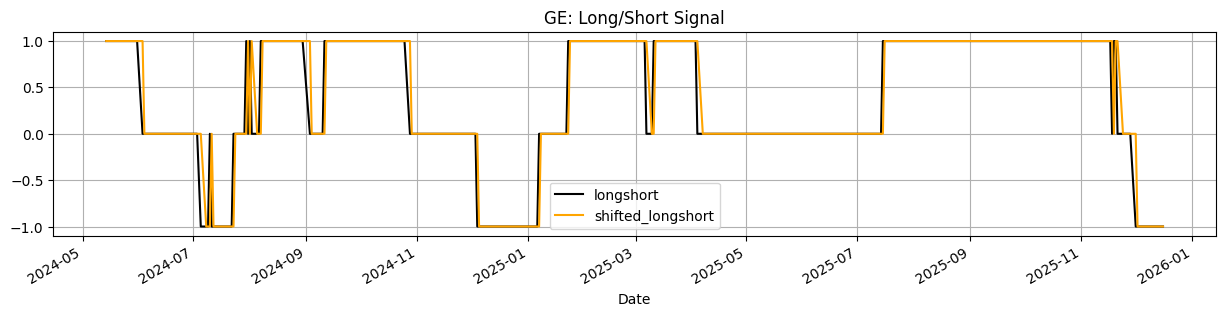

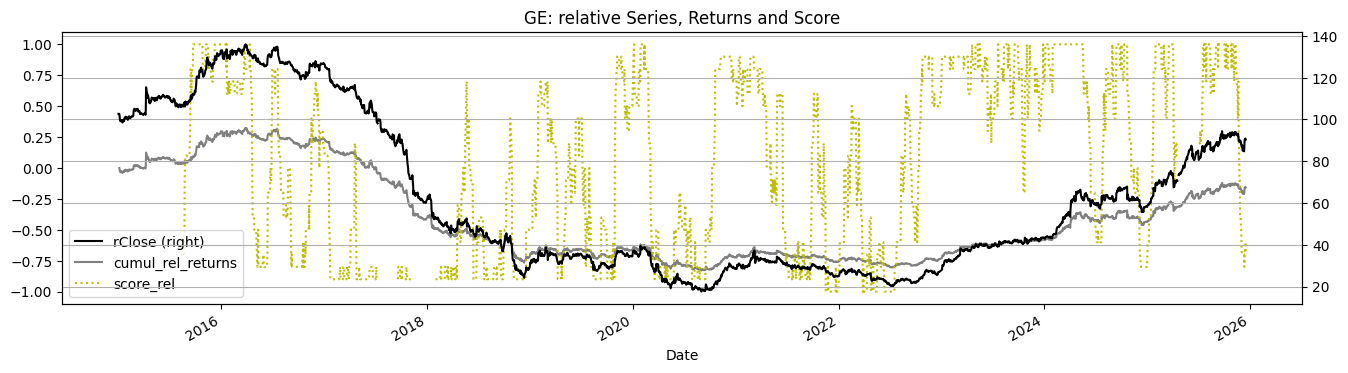

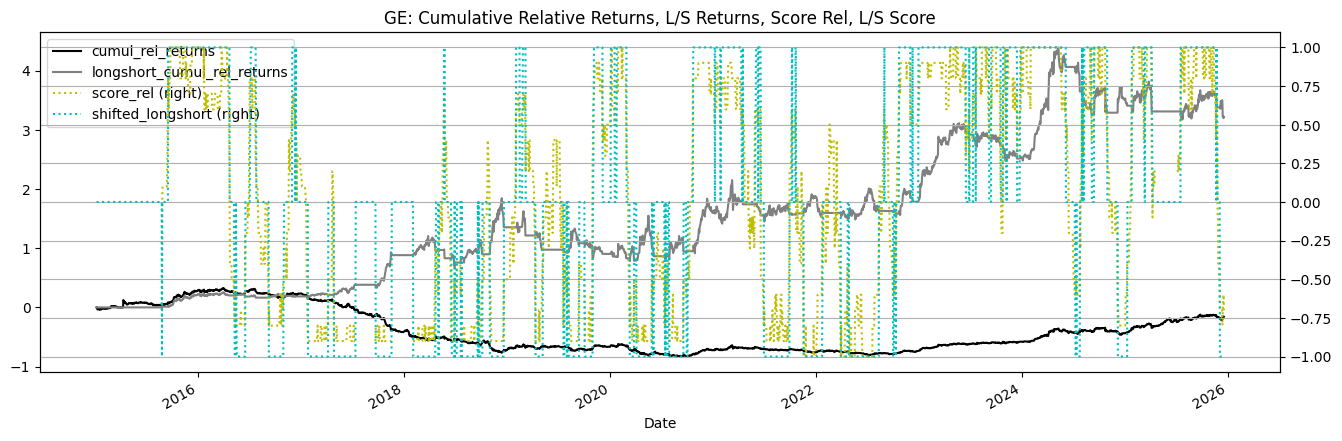

In [6]:
data = ticker_raw_data[['score_rel','rClose', 'Close']].copy()

data['longshort'] = np.where(data['score_rel'] > 0.5 , 1, np.where(data['score_rel'] < -0.5, -1, 0))
data['shifted_longshort'] = data['longshort'].shift(+1)
data[-400:][['longshort','shifted_longshort',]].plot(figsize=(15, 3), style=['k', 'orange'], title=f'{ticker}: Long/Short Signal', grid=True)


data['log_returns_rel_1D'] = np.log(data['rClose'] / data['rClose'].shift())
data['cumul_rel_returns'] = data['log_returns_rel_1D'].cumsum().apply(np.exp) - 1
data[['rClose', 'cumul_rel_returns','score_rel',]].plot(figsize=(16, 4), secondary_y=['rClose'], style=['k',  'grey','y:'], 
                                                        title=f'{ticker}: relative Series, Returns and Score', grid=True)

data['longshort_rel_1D_returns'] = data['log_returns_rel_1D'] * data['shifted_longshort']                         
data['longshort_cumul_rel_returns'] = data['longshort_rel_1D_returns'].cumsum().apply(np.exp) - 1
data[[ 'cumul_rel_returns', 'longshort_cumul_rel_returns','score_rel', 'shifted_longshort']].plot(figsize=(16, 5), secondary_y= ['shifted_longshort','score_rel'],
                                                style=['k', 'grey', 'y:','c:'], title=f'{ticker}: Cumulative Relative Returns, L/S Returns, Score Rel, L/S Score', grid =True)

#### Strategy Signal Generation and Return Analysis

**Objective:** Transform regime scores into actionable long/short trading signals, calculate both buy-and-hold and strategy-specific returns, and visualize performance across multiple timeframes.

**Signal Generation Logic:**
- Extract regime score (`score_rel`), relative close price (`rClose`), and absolute close price from ticker data
- Generate binary trading signals based on score thresholds:
  - **Long (+1)**: `score_rel > 0.5` → bullish regime, enter long position
  - **Short (-1)**: `score_rel < -0.5` → bearish regime, enter short position  
  - **Flat (0)**: `-0.5 ≤ score_rel ≤ 0.5` → neutral regime, no position
- Apply one-day forward shift to signals (`shift(+1)`) to simulate realistic trade execution (signal observed at close, trade executed next day)

**Return Calculations:**
1. **Buy-and-Hold Returns:**
   - Calculate daily log returns: `ln(rClose_t / rClose_t-1)`
   - Compound into cumulative returns: `exp(Σ log_returns) - 1`
   - Serves as baseline for strategy comparison

2. **Strategy Returns:**
   - Multiply daily log returns by shifted position (long/short/flat)
   - Only capture returns when actively positioned (filters out flat periods)
   - Compound strategy returns to track long-short performance

**Visualization Outputs:**
1. **Signal Timing Chart** (last 400 bars): Compares current vs. shifted signals to verify lag implementation
2. **Price & Score Chart**: Overlays relative price, cumulative returns, and regime score to identify regime transitions
3. **Strategy Performance Chart**: Compares buy-and-hold returns vs. long-short strategy returns with signals overlaid on secondary axis

**Key Features:**
- Realistic signal lag prevents look-ahead bias
- Log returns enable accurate compounding and statistical analysis
- Dual y-axis plots separate price/return scales from normalized scores
- Color-coded styling (black/grey/yellow/cyan) distinguishes series types

**Result:** Complete trading simulation framework with visual confirmation of signal timing, return attribution, and strategy edge vs. passive holding.

#### Strategy Simulation: Signal Generation and Long/Short Returns

**Objective:** Convert regime scores into trading signals and calculate daily/cumulative returns for both long-short strategy and buy-and-hold reference positions.

**Steps:**
- Extract regime score (`score_rel`), relative close price (`rClose`), and absolute close from raw ticker data; create binary long/short signals where score > 0.5 → long (+1), score < -0.5 → short (-1), else flat (0).
- Shift signals forward by one day to simulate real trading (trades entered day-after-signal), visualizing last 400 bars to observe signal timing.
- Calculate log returns from price series; compute cumulative returns via sum-then-exp transformation; plot buy-and-hold returns alongside regime score for comparison.
- Multiply daily log returns by shifted positions to extract strategy-only returns; compound into cumulative strategy returns for performance visualization.

**Result:** DataFrame with trading signals, daily/cumulative returns for buy-and-hold, and strategy-conditional returns, enabling quick comparison of regime-based edge vs. passive holding.

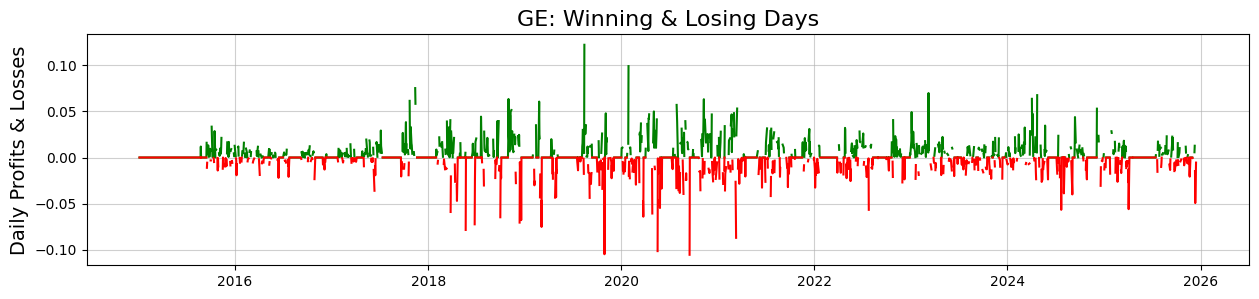

In [7]:
def daily_profits(daily_returns):
    profits = daily_returns.copy()
    profits[profits < 0] = np.nan
    return profits

def daily_losses(daily_returns):
    losses = daily_returns.copy()
    losses[losses > 0] = np.nan
    return losses    

winning_days = daily_profits(data['longshort_rel_1D_returns'])
losing_days = daily_losses(data['longshort_rel_1D_returns'])

plt.figure(figsize=(15, 3))
plt.plot(winning_days, 'g', label='Winning Days')
plt.plot(losing_days, 'r', label='Winning Days')
plt.title(f'{ticker}: Winning & Losing Days', fontsize=16)
plt.ylabel('Daily Profits & Losses', fontsize=14)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

#### Win/Loss Separation and Visualization

**Objective:** Decompose daily strategy returns into winning and losing days, then visualize profit/loss distribution to assess trade quality.

**Steps:**
- `daily_profits()`: Copy daily returns series and mask all losses (set < 0 → NaN) to isolate winning trades for aggregation.
- `daily_losses()`: Copy daily returns series and mask all gains (set > 0 → NaN) to isolate losing trades for aggregation.
- Extract winning/losing days from strategy returns (`longshort_rel_1D_returns`); plot both series on same chart with green for wins, red for losses.
- Visual inspection reveals win/loss clustering, magnitude patterns, and drawdown severity to inform trade quality assessment.

**Result:** Series of profitable vs. unprofitable days plotted over time, enabling visual identification of high-consequence loss periods and win streaks.

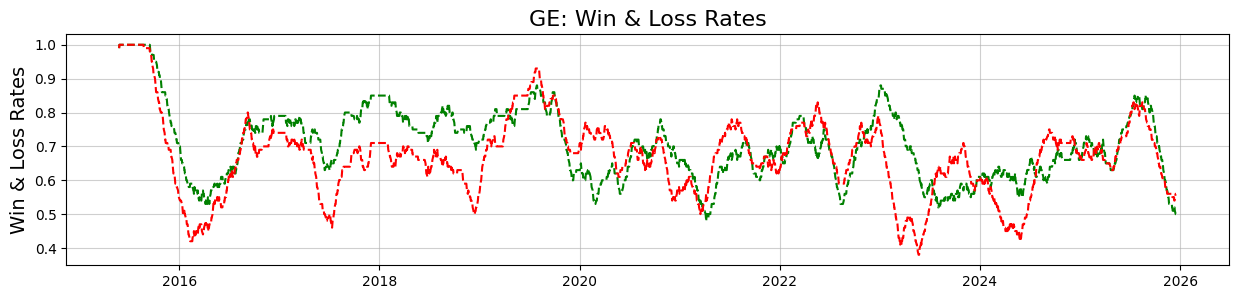

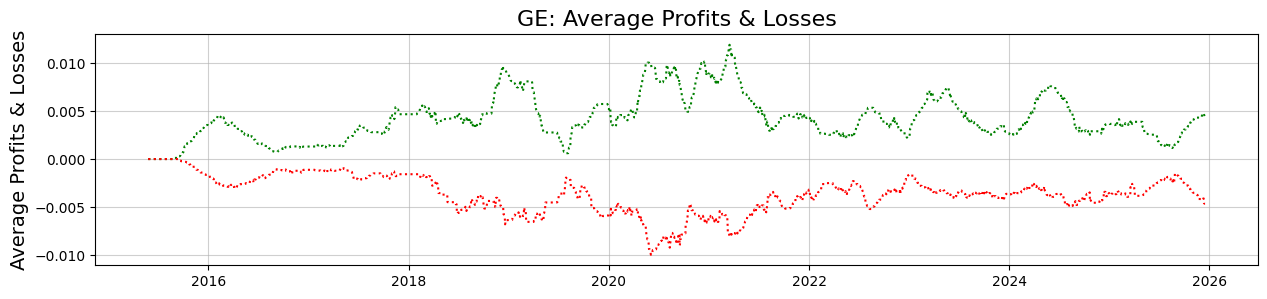

In [8]:
window = 100
win_rate = winning_days.rolling(window).count() / window
loss_rate = losing_days.rolling(window).count() / window
avg_win = winning_days.fillna(0).rolling(window).mean()
avg_loss = losing_days.fillna(0).rolling(window).mean()

plt.figure(figsize=(15, 3))
plt.plot(win_rate, 'g--', label='Winning Days')
plt.plot(loss_rate, 'r--', label='Winning Days')
plt.title(f'{ticker}: Win & Loss Rates', fontsize=16)
plt.ylabel('Win & Loss Rates', fontsize=14)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(avg_win, 'g:', label='Winning Days')

plt.plot(avg_loss, 'r:', label='Winning Days')
plt.title(f'{ticker}: Average Profits & Losses', fontsize=16)
plt.ylabel('Average Profits & Losses', fontsize=14)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

#### Rolling Win Rates, Loss Rates, and Average Trade Magnitudes

**Objective:** Compute rolling-window statistics (win rate, loss rate, average win, average loss) over a fixed lookback period to assess strategy performance evolution over time.

**Steps:**
- Define rolling window size (e.g., 100 days); count winning days per window divided by window size to yield rolling win-rate; similarly compute rolling loss-rate from losing days.
- Compute rolling average of winning trades (ignoring zeros) and rolling average of losing trades to track average magnitude per win/loss over time.
- Plot win/loss rates on same chart (green dashes for wins, red dashes for losses) to visualize shifting trade quality across time; separately plot average win/loss magnitudes.
- Overlay rates and magnitudes reveals periods of consistent wins vs. clustered drawdowns, enabling regime-specific performance assessment.

**Result:** Time series of rolling win rates, loss rates, and trade magnitudes enabling identification of high-quality trading periods vs. underwater drawdown phases.

<Axes: title={'center': 'GE: Trading Edge, Geometric Expectancy, Kelly Criterion'}, xlabel='Date'>

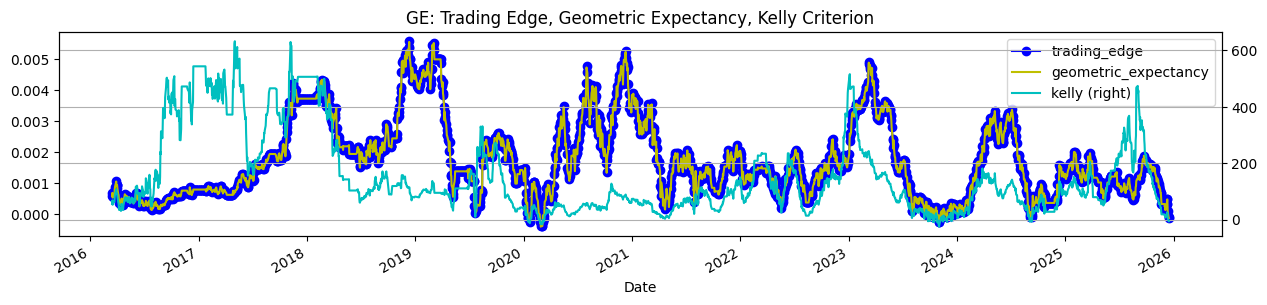

In [9]:
data['trading_edge'] = expectancy(win_rate,avg_win, avg_loss).ffill()
data['geometric_expectancy'] = geometric_expectancy(win_rate ,avg_win, avg_loss).ffill()
data['kelly'] = kelly(win_rate, avg_win,avg_loss).ffill()
data[window *3:][['trading_edge', 'geometric_expectancy', 'kelly']].plot(secondary_y = 'kelly', style = ['b-o', 'y-', 'c'], figsize=(15, 3), 
                                                                         title=f'{ticker}: Trading Edge, Geometric Expectancy, Kelly Criterion', grid=True)

#### Profit Ratio: Rolling and Cumulative Win-to-Loss Magnitude Ratio

**Objective:** Calculate profit ratio metrics comparing total winning amounts to total losing amounts, measured both over rolling windows and cumulatively, to assess strategy profitability consistency.

**Steps:**
- `profit_ratio()`: Define helper function dividing cumulative/rolling profits (sum of winning trades) by absolute cumulative/rolling losses (sum of losing trades) with forward-fill to handle NaN edges.
- Compute rolling profit ratio: divide rolling sum of wins (over 100-day window) by rolling sum of losses to track period-specific win-to-loss magnitude; reveals periods where wins outweigh losses.
- Compute cumulative profit ratio: divide total wins from inception by total losses from inception to track long-term profitability trend; should rise if strategy has consistent edge.
- Plot both ratios on same chart (blue for rolling, red for cumulative) starting after 3× window burnin; intersection and divergence patterns reveal edge stability.

**Result:** Time series of profit ratios enabling identification of periods where average winning trade magnitude exceeds average losing magnitude, signaling sustainable strategy edge.

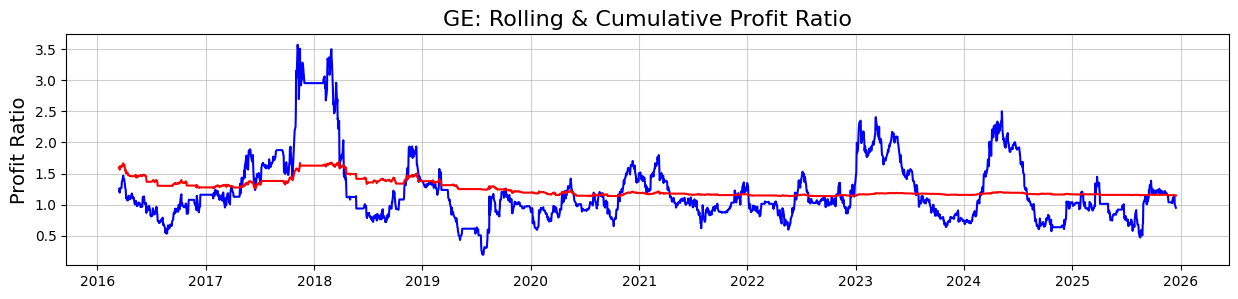

In [10]:
def profit_ratio(profits, losses):    
    pr = profits.ffill() / abs(losses.ffill())
    return pr

rolling_profit_ratio = profit_ratio(winning_days.fillna(0).rolling(window).sum(), losing_days.fillna(0).rolling(window).sum()).ffill()
cumulative_profit_ratio = profit_ratio(winning_days.fillna(0).cumsum(), losing_days.fillna(0).cumsum()).ffill()

plt.figure(figsize=(15, 3))
plt.plot(rolling_profit_ratio[window * 3:], 'b', label='Rolling Profit Ratio')
plt.plot(cumulative_profit_ratio[window * 3:], 'r', label='Cumulative Profit Ratio')
plt.title(f'{ticker}: Rolling & Cumulative Profit Ratio', fontsize=16)
plt.ylabel('Profit Ratio', fontsize=14)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

#### Profit Ratio: Rolling and Cumulative Win-to-Loss Magnitude Ratio

**Objective:** Calculate profit ratio metrics comparing total winning amounts to total losing amounts, measured both over rolling windows and cumulatively, to assess strategy profitability consistency.

**Steps:**
- `profit_ratio()`: Define helper function dividing cumulative/rolling profits (sum of winning trades) by absolute cumulative/rolling losses (sum of losing trades) with forward-fill to handle NaN edges.
- Compute rolling profit ratio: divide rolling sum of wins (over 100-day window) by rolling sum of losses to track period-specific win-to-loss magnitude; reveals periods where wins outweigh losses.
- Compute cumulative profit ratio: divide total wins from inception by total losses from inception to track long-term profitability trend; should rise if strategy has consistent edge.
- Plot both ratios on same chart (blue for rolling, red for cumulative) starting after 3× window burnin; intersection and divergence patterns reveal edge stability.

**Result:** Time series of profit ratios enabling identification of periods where average winning trade magnitude exceeds average losing magnitude, signaling sustainable strategy edge.

In [ ]:

def rolling_tail_ratio(cumul_returns, window, percentile,limit):
    left_tail = np.abs(cumul_returns.rolling(window).quantile(percentile))
    right_tail = cumul_returns.rolling(window).quantile(1-percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail,limit),-limit)
    return tail

def expanding_tail_ratio(cumul_returns, percentile,limit):
    left_tail = np.abs(cumul_returns.expanding().quantile(percentile))
    right_tail = cumul_returns.expanding().quantile(1 - percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail,limit),-limit)
    return tail


#### Tail Ratio Metrics: Return Distribution Asymmetry Analysis

**Objective:** Define functions to measure return distribution skewness by comparing right-tail (gains) to left-tail (losses) magnitudes, quantifying strategy bias toward large winners vs. large losers.

**Steps:**
- `rolling_tail_ratio()`: Calculate rolling window quantiles at specified percentile (e.g., 5th percentile for left tail, 95th percentile for right tail); divide right-tail value by absolute left-tail value to create ratio metric; apply min/max limits to cap extreme outliers; suppress numpy warnings for division operations.
- `expanding_tail_ratio()`: Same calculation using expanding window instead of rolling window; tracks tail ratio evolution from inception to present, capturing long-term distribution asymmetry trends.
- Both functions use `np.maximum(np.minimum())` to constrain tail ratio within [-limit, +limit] bounds, preventing inf/nan from division by near-zero values.
- Positive tail ratio (>1) indicates right-skewed distribution with larger gains than losses; negative or <1 indicates left-skewed distribution with larger losses.

**Result:** Two complementary tail ratio functions enabling assessment of return distribution quality: rolling version tracks recent distribution changes, expanding version reveals cumulative distribution characteristics; both quantify whether strategy generates asymmetric payoffs favoring large winners over large losers.

In [11]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)}'} 
response = requests.get(url, headers=headers)
df_SP500 = pd.read_html(response.text)[0]


df_SP500 = df_SP500.rename(columns={'Symbol':'ticker', 'Security': 'name', 'GICS Sector':'sector','GICS Sub-Industry':'sub-industry'})
df_SP500['ticker'] = df_SP500['ticker'].str.replace('.', '-', regex =False)
df_SP500 = df_SP500.sort_values(by = ['sector','name']).set_index('ticker')
df_SP500 = df_SP500[df_SP500.index.isin(library_SP500.list_symbols())]

bm_ticker = '^GSPC'   ;  bm = 'SP500' ; ccy = 'local' ; dgt = 2
df_SP500.groupby('sector').count()

/tmp/ipykernel_308193/3952201047.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_SP500 = pd.read_html(response.text)[0]


,name,sub-industry,Headquarters Location,Date added,CIK,Founded
sector,,,,,,
Communication Services,23,23,23,23,23,23
Consumer Discretionary,47,47,47,47,47,47
Consumer Staples,36,36,36,36,36,36
Energy,22,22,22,22,22,22
Financials,76,76,76,76,76,76
Health Care,60,60,60,60,60,60
Industrials,79,79,79,79,79,79
Information Technology,70,70,70,70,70,70
Materials,26,26,26,26,26,26


#### S&P 500 Universe Construction: Sector-Indexed Asset Universe

**Objective:** Download and structure S&P 500 constituent list with sector and company metadata, filtered to only include tickers available in the Arctic database.

**Steps:**
- Fetch S&P 500 component list from Wikipedia using HTTP requests with user-agent header; parse HTML table to extract ticker, company name, GICS sector, and sub-industry classifications.
- Standardize ticker format by replacing dots with dashes (e.g., 'BRK.B' → 'BRK-B') to align with database naming conventions; sort by sector and company name for logical grouping.
- Filter DataFrame to retain only tickers present in `library_SP500.list_symbols()`, removing any delisted or missing-data tickers from database.
- Set ticker as index and define global trading parameters: benchmark ticker (^GSPC), benchmark label, currency ('local'), and decimal precision (2).
- Display sector-wise breakdown showing number of constituents per sector for universe composition verification.

**Result:** Indexed DataFrame with S&P 500 universe, sector metadata, and company names filtered to database availability; enables sector-level analysis and pairs discovery.

In [ ]:
def cointegration_test(df, cutoff):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    colname = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            p1 = df[colname[i]]
            p2 = df[colname[j]]
            cointegration_matrices = coint(p1, p2)
            score = cointegration_matrices[0]
            pvalue = cointegration_matrices[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < cutoff:
                pairs.append((colname[i], colname[j]))
    return pairs, pvalue_matrix, score_matrix

def historical_spread(df,pair):
    pair_1 = df[pair[0]]
    pair_2 = df[pair[1]]
    pair_1  = add_constant(df[pair[0]])
    results = OLS(pair_2, pair_1).fit()
    coeff = results.params[pair[0]]
    spread = df[pair[1]] - (coeff * df[pair[0]])
    return spread

def price_ratio(df,pair):
    return df[pair[0]] / df[pair[1]]

def price_spread(df,pair):
    return df[pair[0]] - df[pair[1]]

def rolling_Z_score(df, t):    
    Z_score = (df - df.rolling(t).mean()) / df.rolling(t).std(ddof=0)
    return Z_score

#### Pairs Discovery: Cointegration Testing and Spread Calculations

**Objective:** Implement helper functions to identify cointegrated asset pairs and compute multiple spread representations (regression-based, ratio, difference) for pairs trading strategies.

**Steps:**
- `cointegration_test()`: Perform pairwise Engle-Granger cointegration tests across all asset combinations; compute t-statistic (ADF test on residuals) and p-value for each pair; populate symmetric matrices and filter pairs below p-value cutoff (e.g., 0.05) to identify statistically significant long-run equilibrium relationships.
- `historical_spread()`: Regress price_2 on price_1 using OLS with constant term; extract regression coefficient and compute residual spread as price_2 - (coefficient × price_1), capturing the regression-based pair relationship.
- `price_ratio()`: Calculate simple ratio spread (price_1 / price_2) to represent relative value divergence; useful for mean-reversion signals when ratio deviates from historical norm.
- `price_spread()`: Compute simple difference spread (price_1 - price_2) as linear pair relationship alternative; sensitive to absolute price levels but intuitive for visualization.
- `rolling_Z_score()`: Standardize time series over rolling window using z-score transformation: (value - rolling_mean) / rolling_std; enables threshold-based entry/exit signals independent of spread magnitude.

**Result:** Suite of cointegration discovery and spread calculation functions enabling sector-level pairs screening, multiple spread representations for signal generation, and rolling normalization for threshold-based trading rules.

In [ ]:
cutoff = 0.05 ; lookback_years = 3
coint_window = px_df.index.max() - relativedelta(years=lookback_years)
df = px_df[coint_window:].copy()
sector_list = list(set(df_SP500['sector']))
sector_pairs_dict = {}  ; bm_pairs_list = []
failed_list = []

for sctr in sector_list:
    sector_tickers = [bm_ticker] + list(df_SP500[df_SP500['sector'] == sctr].index)
    print(f'{sctr}: {len(sector_tickers)} stocks, ',end="")
    pairs, pvalue_matrix, score_matrix = cointegration_test(df.loc[:,sector_tickers].fillna(0), cutoff)
    sector_pairs_dict.update({sctr: pairs})
    bm_pairs_list += [bm_pair for bm_pair in pairs if bm_ticker in bm_pair]
    print(f'{len(pairs)} pairs')    
    
print('bm_pairs_list:', len(bm_pairs_list), bm_pairs_list)
sector_pairs_df = pd.DataFrame.from_dict(sector_pairs_dict, orient='index').T
sector_pairs_df

In [ ]:
sector_pairs_df.to_csv('sector_pairs_df.csv')

In [128]:
sector_pairs_df = pd.read_csv('sector_pairs_df.csv', index_col=0)#.iloc[:, 0:]

cutoff = 0.05 ; lookback_years = 3
coint_window = px_df.index.max() - relativedelta(years = lookback_years)
df = px_df[coint_window:].copy()

In [129]:

sector_pairs_count = pd.concat([df_SP500.groupby('sector').count()['name'], 
                                sector_pairs_df.count()],axis=1, keys=['#Stocks', '#Pairs']).rename_axis('sector').astype(int).sort_index()
sector_pairs_count

,#Stocks,#Pairs
sector,,
Communication Services,23,9
Consumer Discretionary,47,101
Consumer Staples,36,16
Energy,22,77
Financials,76,123
Health Care,60,109
Industrials,79,166
Information Technology,70,45
Materials,26,15


#### Sector-Level Pairs Discovery: Cointegration Screening Across GICS Sectors

**Objective:** Screen for cointegrated pairs within each GICS sector and against the S&P 500 benchmark, building a dataset of statistically significant long-run equilibrium relationships for pairs trading.

**Steps:**
- Define cointegration window: extract 3-year historical price data from full S&P 500 price universe; set p-value cutoff (e.g., 0.05) for statistical significance threshold on cointegration tests.
- For each GICS sector: extract sector constituents from filtered S&P 500 universe; prepend benchmark ticker (^GSPC) to sector list to identify pairs correlated with overall market; pass sector+benchmark to `cointegration_test()` function.
- Perform pairwise cointegration testing on sector-specific prices; store all cointegrated pairs by sector in dictionary; separately capture benchmark pairs (pairs containing ^GSPC) in `bm_pairs_list` for market-hedged strategies.
- Reshape sector_pairs_dict from dictionary to DataFrame with sectors as columns and pairs as rows (pivot structure); enables efficient pair lookup and aggregation across sectors.
- Print progress: display sector name, total stocks (sector + benchmark), number of cointegrated pairs for each sector; display summary of benchmark pairs and final DataFrame structure.

**Result:** Sector-indexed pairs discovery with cointegrated relationships identified for 11+ GICS sectors; benchmark pairs enabling market-neutral strategy pairs; foundation for spread-based mean-reversion signals across sector portfolios.

In [130]:
historical_spread_dict = {} ; price_spread_dict = {} ; price_ratio_dict = {} ; pairs_list = []    ;   failed_list = []

x= 0
while x < len(sector_pairs_df.columns):
    print(x+1,sector_pairs_df.columns[x],sector_pairs_df.iloc[:,x].count(),end = ' pairs:') 
    y= 0
    while (y<len(sector_pairs_df)) & (pd.notnull(sector_pairs_df.iloc[min(y,len(sector_pairs_df)-1),x]))  :
        try:
            pair = eval(sector_pairs_df.iloc[y,x])
            spread = abs(historical_spread(df,pair))
            adf_spread = adfuller(spread)[1]            
            
            ratio = price_ratio(df,pair)            
            adf_ratio = adfuller(ratio)[1]
            
            adf_avg = (adf_spread * adf_ratio) ** 0.5
            if adf_avg <= cutoff:
                historical_spread_dict.update({pair: spread})                
                price_ratio_dict.update({pair:ratio})        
                price_spread_dict.update({pair: price_spread(df,pair)})  
                pair_dict = {'pair':pair, 'sector':sector_pairs_df.columns[x], 'adf_spread': adf_spread, 'adf_ratio': adf_ratio, 'adf_avg': adf_avg}
                pairs_list +=[pair_dict]
            print(pair,end = ',')
        except:
            failed_list.append(pair)
        y +=1
    x += 1
    print('')
    
historical_spread_df = pd.DataFrame.from_dict(historical_spread_dict).round(3)
price_ratio_df = pd.DataFrame.from_dict(price_ratio_dict).round(3)
price_spread_df = pd.DataFrame.from_dict(price_spread_dict).round(3)
pairs_df = pd.DataFrame.from_dict(pairs_list).round(4)
pairs_df = pairs_df.set_index('pair')
print('price_spread_df:' ,price_spread_df.shape ,'price_ratio_df:',price_ratio_df.shape,'pairs_df:', pairs_df.shape)
print(f'Failed list: {len(failed_list)}, {failed_list}')

1 Industrials 166 pairs:('^GSPC', 'LDOS'),('^GSPC', 'NOC'),('^GSPC', 'PH'),('AOS', 'BLDR'),('AOS', 'PAYC'),('ALLE', 'LHX'),('ALLE', 'NSC'),('ALLE', 'NOC'),('AME', 'DAL'),('AME', 'EMR'),('AME', 'HUBB'),('AME', 'LDOS'),('AME', 'NSC'),('AME', 'PH'),('AXON', 'DE'),('AXON', 'HON'),('BR', 'UPS'),('CTAS', 'HON'),('CTAS', 'TDG'),('CTAS', 'WM'),('DAY', 'VRSK'),('DE', 'HWM'),('DAL', 'EMR'),('DAL', 'PH'),('ETN', 'LDOS'),('EMR', 'PH'),('EMR', 'UPS'),('FDX', 'PAYC'),('GE', 'NOC'),('GNRC', 'GD'),('GNRC', 'HON'),('GNRC', 'HUBB'),('GNRC', 'LHX'),('GNRC', 'LDOS'),('GNRC', 'NSC'),('GNRC', 'NOC'),('GNRC', 'TT'),('HON', 'HWM'),('HON', 'HUBB'),('HON', 'LDOS'),('HON', 'PH'),('HON', 'SNA'),('HON', 'TT'),('HON', 'TDG'),('HON', 'UBER'),('HON', 'UAL'),('HON', 'UPS'),('HON', 'GWW'),('HON', 'WM'),('HUBB', 'LDOS'),('IR', 'MAS'),('IR', 'UNP'),('MAS', 'UNP'),('NSC', 'NOC'),('NSC', 'PH'),('NOC', 'PH'),('NOC', 'RTX'),('NOC', 'UPS'),('OTIS', 'GWW'),('OTIS', 'WM'),('PCAR', 'UNP'),('PAYC', 'TXT'),('PAYC', 'UNP'),('LUV', 

#### Stationarity Verification and Multi-Spread Construction: Pairs Qualification

**Objective:** For each cointegrated pair, compute regression-based and simple spreads, verify stationarity using ADF tests on both representations, filter pairs meeting statistical criteria, and construct final spread DataFrames for trading signal generation.

**Steps:**
- Iterate through sector_pairs_df columns (sectors) and rows (pairs within each sector); for each pair, retrieve sector identifier and pair tuple.
- For each pair: compute historical (regression-based) spread via OLS residuals; perform ADF stationarity test on spread (p-value); compute price ratio (simple division); perform ADF test on ratio.
- Calculate combined stationarity metric: geometric mean of spread and ratio p-values (adf_avg); filter pairs where adf_avg ≤ cutoff (e.g., 0.05) to retain only statistically significant mean-reverting spreads.
- Store qualifying pairs: regression spread → historical_spread_dict, ratio → price_ratio_dict, simple difference → price_spread_dict; create metadata dict with pair, sector, and both p-values; accumulate in pairs_list.
- Print progress per sector showing pair count and tested pair tickers; capture failed pairs in failed_list for error tracking; convert dictionaries to DataFrames (one pair per column) with 3 decimal rounding for spreads and 4 decimals for metadata.

**Result:** Three aligned wide-format DataFrames (spreads/ratios as columns, dates as rows): historical_spread_df (regression residuals), price_ratio_df (ratios), price_spread_df (differences); pairs_df metadata with sector and ADF statistics; all pairs meet stationarity threshold enabling mean-reversion trading.

In [132]:
duration_list = list(range(20, 101, 20))
z_df_dict = {}
for t in duration_list:
    z_df_dict[f'z_spread{t}'] = round(rolling_Z_score(price_spread_df, t),2)
    z_df_dict[f'z_ratio{t}'] = round(rolling_Z_score(price_ratio_df, t),2)

#### Multi-Timeframe Z-Score Normalization: Signal Standardization Across Lookback Periods

**Objective:** Compute rolling z-score standardization on spread and ratio DataFrames across multiple timeframes (20, 40, 60, 80, 100 days) to generate scale-independent entry/exit signals independent of spread magnitude or drift.

**Steps:**
- Define duration_list: create list of rolling window sizes [20, 40, 60, 80, 100] days using range(20, 101, 20) to span short-term reactive signals through longer-term trend filters.
- Initialize empty z_df_dict dictionary to store all z-score DataFrames indexed by window size and spread type.
- For each timeframe t in duration_list: apply `rolling_Z_score()` function to price_spread_df (simple difference spreads) producing z-normalized spreads; store in z_df_dict with key `f'z_spread{t}'` (e.g., 'z_spread20', 'z_spread40', ..., 'z_spread100').
- Repeat z-score calculation for price_ratio_df (price ratios) at same window sizes; store with key `f'z_ratio{t}'` (e.g., 'z_ratio20', 'z_ratio40', ..., 'z_ratio100').
- Z-score transformation formula: (spread - rolling_mean) / rolling_std with ddof=0, standardizing each spread/ratio to zero mean and unit variance over respective windows.
- Round all z-scores to 2 decimals for signal clarity and consistent threshold comparisons across pairs.

**Result:** Dictionary z_df_dict containing 10 z-score DataFrames (5 windows × 2 spread types): pairs as columns, dates as rows; all spreads/ratios converted to standardized normal distribution enabling consistent threshold-based entry triggers (e.g., |z| > 2.0 for mean-reversion signals) across different pairs, spread magnitudes, and timeframes; shorter windows capture tactical reversions, longer windows filter noise for strategic positioning.

In [126]:
z_last_list = []
for z in z_df_dict:
    z_last_list += [z_df_dict[z].tail(1).T.rename(columns={z_df_dict[z].index.max(): z})]    
z_last_df = pd.concat(z_last_list,axis=1)
z_last_df.index.name = "pair"

pairs_df = pd.concat([pairs_df, z_last_df], axis=1).dropna(subset=['adf_avg'])
pairs_df = pairs_df.loc[:, ~pairs_df.columns.duplicated(keep='last')]  

#### Latest Z-Score Snapshot: Pair Metadata Enhancement

**Objective:** Extract most recent z-score values across all timeframes and spread types, merge with pair metadata to create enriched screening DataFrame showing current pair positioning.

**Steps:**
- Initialize empty `z_last_list` to accumulate transposed z-score snapshots for concatenation.
- Iterate through z_df_dict containing 10 z-score DataFrames (5 windows × 2 spread types: z_spread20/40/60/80/100, z_ratio20/40/60/80/100).
- For each z-score DataFrame: extract last row (most recent date) using `.tail(1)`; transpose (`.T`) to convert pairs from columns to rows; rename single column from date timestamp to z-score identifier (e.g., 'z_spread20', 'z_ratio100').
- Append each transposed single-column DataFrame to z_last_list; after loop completes, concatenate all horizontally using `pd.concat(z_last_list, axis=1)` to create z_last_df with pairs as rows and 10 z-score columns.
- Set index name to "pair" for clarity; merge z_last_df with existing pairs_df metadata (sector, adf_spread, adf_ratio, adf_avg) using horizontal concatenation on pair index.
- Drop rows missing ADF statistics (`dropna(subset=['adf_avg'])`) to retain only qualified cointegrated pairs; remove duplicate columns (`.loc[:, ~pairs_df.columns.duplicated(keep='last')]`) from any prior merge collisions.

**Result:** Consolidated pairs_df DataFrame with sector classification, stationarity metrics (ADF p-values), and latest z-scores across all 10 timeframe/spread-type combinations; enables immediate screening for extreme positioning (e.g., |z| > 2.0 on multiple timeframes) signaling high-confidence mean-reversion entry candidates; ready for sector-specific pair filtering and multi-timeframe signal convergence analysis.

In [133]:
utilities_pairs_df = pairs_df[pairs_df['sector'] == 'Utilities'].sort_values(by='adf_avg').rename_axis('pair')
utilities_pairs_df

,sector,adf_spread,adf_ratio,adf_avg
pair,,,,
"(CMS, PPL)",Utilities,0.0000,0.2051,0.0031
"(DTE, DUK)",Utilities,0.0017,0.0158,0.0051
"(^GSPC, CEG)",Utilities,0.0001,0.8116,0.0100
"(CMS, DTE)",Utilities,0.0110,0.0132,0.0121
"(CMS, DUK)",Utilities,0.0025,0.0805,0.0140
"(DTE, PPL)",Utilities,0.0032,0.1320,0.0204
"(CEG, NRG)",Utilities,0.0138,0.0478,0.0257
"(CNP, WEC)",Utilities,0.2309,0.0043,0.0313
"(PPL, VST)",Utilities,0.0023,0.4369,0.0317


#### Sector shortlist: rank pairs within a sector
- Filter pairs_df to a single sector (Utilities).
- Sort by adf_avg ascending (smaller p-values → stronger stationarity).
- Change the sector name to inspect others; set ascending=False to surface weaker candidates.

<Axes: title={'center': 'CMS & PPL: Price Series & Spread'}, xlabel='Date'>

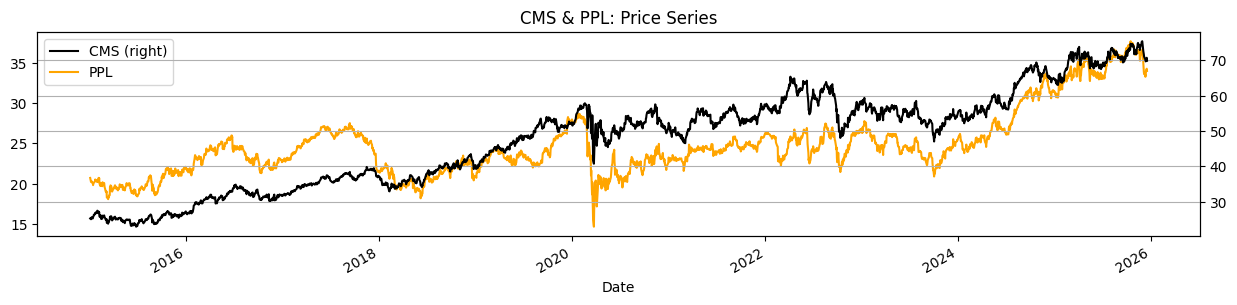

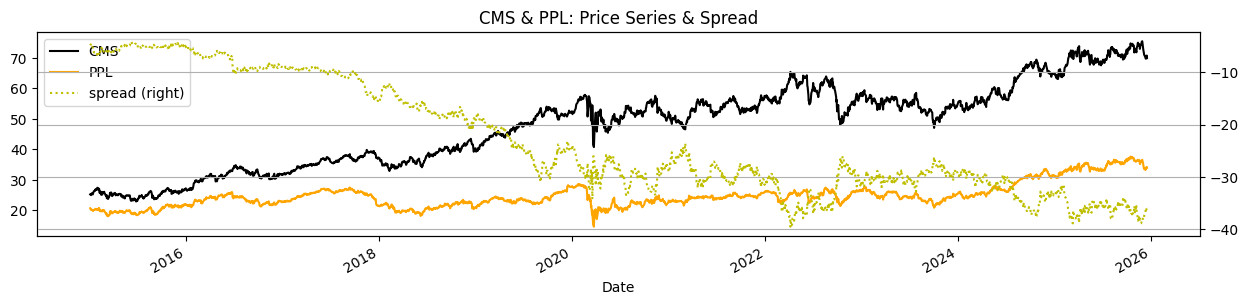

In [143]:
pair =  utilities_pairs_df[utilities_pairs_df['adf_avg']>0].index[0]
px_df[[pair[0], pair[1]]].plot(figsize=(15, 3), style=['k', 'orange'], secondary_y = pair[0] ,
                               title=f'{pair[0]} & {pair[1]}: Price Series', grid=True)

df_pair = px_df[[pair[0], pair[1]]].ffill().copy()
df_pair['spread'] = round(df_pair[pair[1]] - df_pair[pair[0]],5)
df_pair['spread_daily_log'] = np.log(df_pair['spread']/df_pair['spread'].shift()).round(5)
df_pair[[pair[0], pair[1], 'spread']].plot(figsize=(15, 3), style=['k', 'orange', 'y:'],secondary_y=['spread'],
                                              title=f'{pair[0]} & {pair[1]}: Price Series & Spread', grid=True)

#### Pair Visualization: Price Series and Spread Construction

**Objective:** Select a qualified pair from sector shortlist, visualize price co-movement, and construct simple difference spread with log returns for mean-reversion analysis.

**Steps:**
- Extract first valid pair from utilities_pairs_df (filter adf_avg > 0 to exclude edge cases); plot both leg prices on dual-axis chart (black/orange) to observe historical co-movement and correlation strength.
- Create df_pair DataFrame with forward-filled prices for both legs; compute simple difference spread (leg2 - leg1) rounded to 5 decimals.
- Calculate spread daily log returns: ln(spread_t / spread_t-1) for volatility and stationarity assessment; plot both prices and spread on same chart with spread on secondary y-axis (yellow dotted) to visualize divergence episodes.

**Result:** Dual-chart visualization showing price co-movement and spread deviation; df_pair DataFrame with prices, simple spread, and log returns ready for z-score threshold signals and entry/exit rules.

Index(['z_spread20', 'z_ratio20', 'z_spread40', 'z_ratio40', 'z_spread60',
       'z_ratio60', 'z_spread80', 'z_ratio80', 'z_spread100', 'z_ratio100'],
      dtype='object')

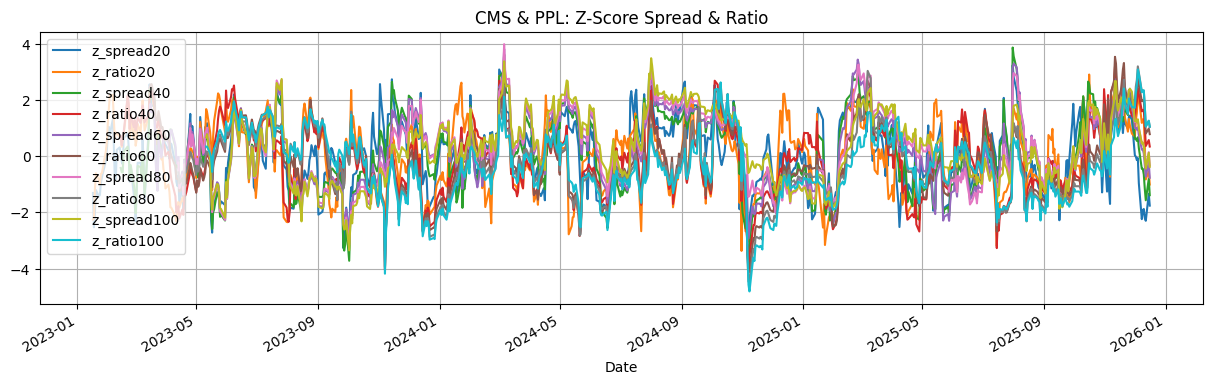

In [144]:
z_pair_dict = {} 
z_pair_dict = {f'{z}': z_df_dict[z][pair] for z in z_df_dict if pair in z_df_dict[z].columns}
z_pair_df = pd.concat(z_pair_dict, axis=1) 
z_pair_df.plot(figsize=(15, 4), title=f'{pair[0]} & {pair[1]}: Z-Score Spread & Ratio', grid=True)
z_pair_df.columns   

#### Multi-Timeframe Z-Score Visualization: Pair Signal Analysis

**Objective:** Extract and visualize all six z-score time series (3 windows × 2 spread types) for selected pair to assess mean-reversion signals across multiple timeframes.

**Steps:**
- Build z_pair_dict by filtering z_df_dict for current pair; extract pair column from each of six z-score DataFrames (z_spread20/60/100, z_ratio20/60/100) if pair exists.
- Concatenate all six z-score series horizontally into z_pair_df with standardized column names; plot all series on single chart with distinct styles (dotted/dashed/solid lines, varied colors).
- Visual overlay reveals signal convergence/divergence across timeframes: short-term z-scores react quickly to spread deviations, long-term z-scores filter noise; extreme readings (|z| > 2) on multiple timeframes signal high-confidence entry opportunities.

**Result:** Multi-timeframe z-score chart for selected pair showing standardized spread positioning across 20/60/100-day windows; enables identification of mean-reversion entry signals when multiple timeframes align at extreme z-score thresholds.

<Axes: title={'center': 'CMS & PPL: Cumulative Spread Returns & Z-Scores'}, xlabel='Date'>

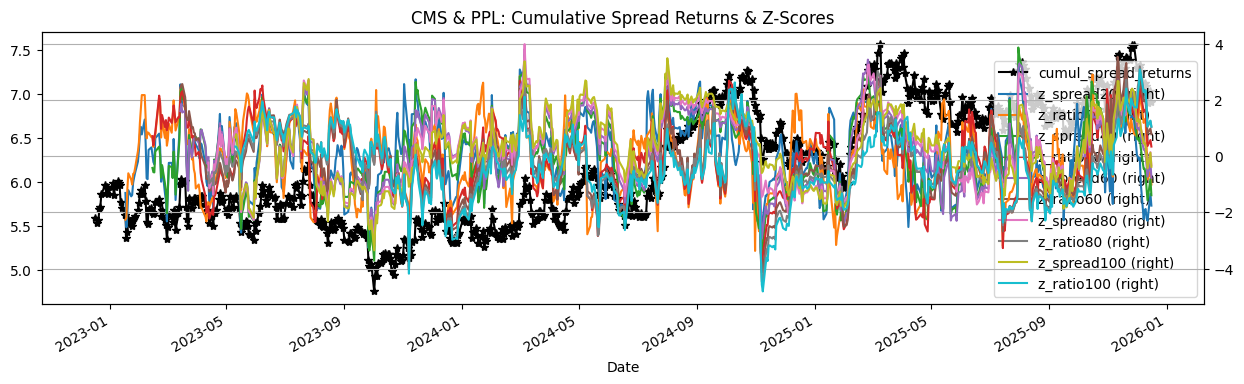

In [147]:
df_pair = px_df[[pair[0], pair[1]]].ffill().copy()
df_pair['spread'] = round(df_pair[pair[0]] - df_pair[pair[1]],5)
df_pair['spread_daily_log'] = np.log(df_pair['spread']/df_pair['spread'].shift()).round(5)
df_pair['cumul_spread_returns'] = df_pair['spread_daily_log'].cumsum().apply(np.exp) - 1
df_pair = pd.concat([df_pair, z_pair_df], axis=1)
plot_cols = [ 'cumul_spread_returns'] + list(z_pair_df.columns)
df_pair[plot_cols][coint_window:].plot(figsize=(15, 4), grid = True, secondary_y = list(z_pair_df.columns),
                                title=f'{pair[0]} & {pair[1]}: Cumulative Spread Returns & Z-Scores', style = ['k-*'] )#+ ['c:','y:','b--','m--','c-','y-','co','yo']) 


#### Cumulative Spread Returns & Z-Score Integration: Signal Visualization with Performance Tracking

**Objective:** Merge cumulative spread returns with multi-timeframe z-scores into unified DataFrame, then visualize spread performance alongside standardized signals to validate mean-reversion opportunities.

**Steps:**
- Forward-fill leg prices from selected pair; compute simple difference spread (leg1 − leg2) rounded to 5 decimals for precision.
- Calculate daily log returns of spread: ln(spread_t / spread_t−1), rounded to 5 decimals; compound into cumulative returns via exp(cumsum) − 1 to track spread performance.
- Concatenate cumulative returns with z_pair_df (six z-score series) horizontally into unified df_pair; align all data to z_pair_df start date (skip burnin period).
- Plot cumulative spread returns on primary y-axis (black line) and all six z-scores on secondary y-axis (varied colors/styles) for dual-perspective visualization.
- Visual overlay shows: spread performance trending vs. z-score extremes; identify entry candidates where |z| > 2.0 across multiple timeframes coincide with spread inflection points.

**Result:** Integrated DataFrame with prices, spreads, daily log returns, cumulative performance, and all z-scores; dual-axis chart enabling quick visual confirmation of mean-reversion setup quality before trade execution.

In [148]:
def pairs_trading_simulator(z_score, entry_threshold, exit_threshold):
    """
    Parameters:
        z_score (pd.Series): The z-score series for the pair.
        entry_threshold (float): The z-score threshold to enter a trade.
        exit_threshold (float): The z-score threshold to exit a trade.
    """
    position = 0  ; trades = []
    for date, z in z_score.items():
        if position == 0:  
            if z > entry_threshold:  # Short entry
                position = -1
                trades.append([date, position])
            elif z < -entry_threshold:  # Long entry
                position = 1
                trades.append([date, position])
        elif position == 1:  # Long position
            if z > -exit_threshold:  # Exit long
                position = 0
                trades.append([date, position])
        elif position == -1:  # Short position
            if z < exit_threshold:  # Exit sho
                position = 0
                trades.append([date, position])
    trades_df = pd.DataFrame(trades, columns=["Date","position"])
    return trades_df

#### Pairs trading simulator: signal-to-position toggling
**Objective:** Convert a z-score signal into discrete long/short/flat positions using symmetric entry/exit thresholds.

**Steps:**
- Initialize `position=0` and an empty `trades` log.
- Iterate over the z-score series:
  - If flat and z > entry_threshold → enter short (-1); if z < -entry_threshold → enter long (+1); log the trade.
  - If long and z > -exit_threshold → exit to flat (0); log the exit.
  - If short and z < exit_threshold → exit to flat (0); log the exit.
- Collect all position changes into `trades_df` with Date and position columns.

**Result:** DataFrame of dated position flips (long, short, flat) driven by z-score threshold crossings, ready for PnL backtesting.

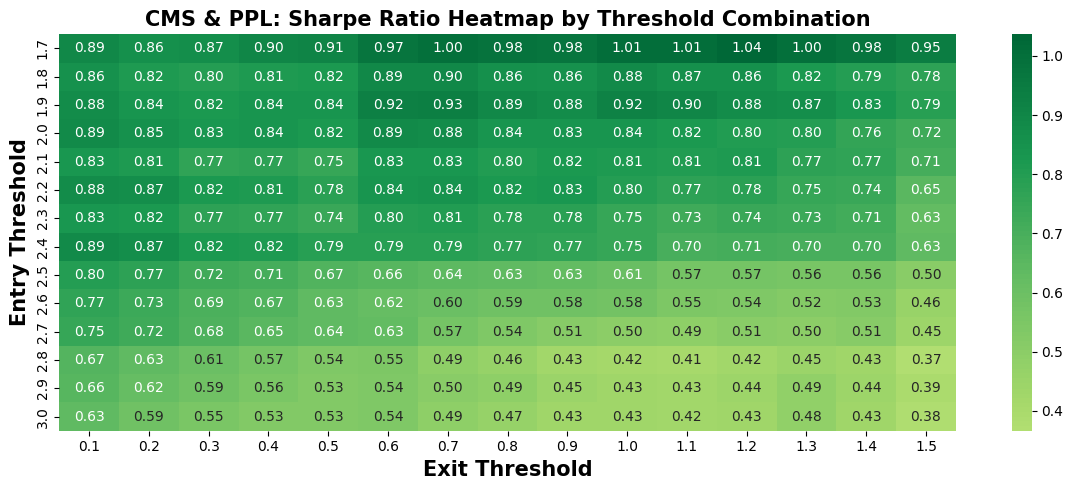

In [ ]:
entry_thresholds = np.arange(1.7, 3.1, 0.1)
exit_thresholds = np.arange(0.1, 1.6, 0.1)
results_list = []
z_score_cols = [col for col in z_pair_df.columns if col.startswith('z_')]

for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        z_pair_df_temp = z_pair_df[z_score_cols].copy()
        pos_list_temp = []        
        for z in z_score_cols:
            pos_df = pairs_trading_simulator(z_pair_df_temp[z], entry_threshold, exit_threshold)
            z_pair_df_temp = pd.concat([z_pair_df_temp, pos_df.set_index('Date')], axis=1)
            z_pair_df_temp.rename(columns={'position': f'pos_{z}'}, inplace=True)
            pos_list_temp += [f'pos_{z}']
        
        z_pair_df_temp = z_pair_df_temp.loc[:, ~z_pair_df_temp.columns.duplicated(keep='last')]
        z_pair_df_temp[pos_list_temp] = z_pair_df_temp[pos_list_temp].shift(+1).ffill()
        
        for pos_col in pos_list_temp:
            df_pair_temp = df_pair.copy()
            position_series = z_pair_df_temp[pos_col].astype(float).fillna(0)
            
            df_pair_temp[f'{pos_col}_daily_log_rets'] = df_pair_temp['spread_daily_log'] * position_series
            df_pair_temp[f'{pos_col}_cum_log_rets'] = df_pair_temp[f'{pos_col}_daily_log_rets'].cumsum()
            df_pair_temp[f'{pos_col}_cumul_returns'] = np.exp(df_pair_temp[f'{pos_col}_cum_log_rets']) - 1
            
            daily_rets = df_pair_temp[f'{pos_col}_daily_log_rets']
            final_return = df_pair_temp[f'{pos_col}_cumul_returns'].iloc[-1]
            max_drawdown = (df_pair_temp[f'{pos_col}_cumul_returns'] / df_pair_temp[f'{pos_col}_cumul_returns'].cummax() - 1).min()
            
            mean_ret = daily_rets.mean()
            std_ret = daily_rets.std()
            sharpe = (mean_ret / std_ret * np.sqrt(252)) if std_ret > 1e-10 else np.nan            
            results_list.append({'entry_threshold': round(entry_threshold, 2), 'exit_threshold': round(exit_threshold, 2),
                'z_score': pos_col, 'sharpe_ratio': sharpe, 'final_return': final_return, 'max_drawdown': max_drawdown})

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('sharpe_ratio', ascending=False).round(4)

pivot_sharpe = results_df.pivot_table(values='sharpe_ratio', index='entry_threshold', 
                                      columns='exit_threshold', aggfunc='mean')
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title(f'{pair[0]} & {pair[1]}: Sharpe Ratio Heatmap by Threshold Combination', fontsize= 15, fontweight='bold')
plt.ylabel('Entry Threshold', fontsize= 15, fontweight='bold')
plt.xlabel('Exit Threshold', fontsize= 15, fontweight='bold')
plt.tight_layout()
plt.show()

#### Multi-Threshold Strategy Optimization: Grid Search for Optimal Entry/Exit Parameters

**Objective:** Systematically test all combinations of entry and exit z-score thresholds across multiple z-score representations to identify optimal parameter sets that maximize risk-adjusted returns (Sharpe ratio) while minimizing drawdowns.

**Steps:**
- Define threshold ranges: entry thresholds from 1.7 to 3.1 in 0.1 increments, exit thresholds from 0.1 to 1.6 in 0.1 increments; creates 14 × 15 = 210 threshold combinations for comprehensive optimization coverage.
- Extract z-score columns from z_pair_df (all series starting with 'z_'); filter to only standardized spread/ratio signals for position generation.
- Nested loop: for each entry/exit threshold pair, iterate through all z-score columns; call `pairs_trading_simulator()` to generate position series with current thresholds; concatenate position columns to temporary z_pair_df_temp; shift positions forward +1 day and forward-fill to align with trading delays.
- For each position column: copy df_pair (prices + spreads); multiply spread daily log returns by position series (float conversion); compute cumulative log returns via cumsum(); compound into cumulative percentage returns using exp() - 1.
- Calculate performance metrics: final cumulative return (last row), maximum drawdown via cummax() comparison, Sharpe ratio = (mean_daily_return / std_daily_return) × √252 with division-by-zero protection.
- Append results dictionary (entry/exit thresholds, z-score identifier, Sharpe, final return, max drawdown) to results_list; iterate through all 210 × 6 = 1,260 strategy combinations.
- Convert results_list to results_df; sort by Sharpe ratio descending (highest risk-adjusted returns first); pivot results by entry/exit thresholds with mean Sharpe as aggregation metric.
- Visualize pivot table as heatmap with seaborn: entry thresholds on y-axis, exit thresholds on x-axis, color intensity representing Sharpe ratio (red = negative Sharpe, green = positive Sharpe); enables quick identification of optimal threshold zones.

**Result:** results_df with 1,260 rows (all threshold × z-score combinations) ranked by Sharpe ratio; heatmap visualization revealing optimal entry/exit threshold combinations with highest risk-adjusted returns; identifies parameter regions where strategy consistently outperforms regardless of z-score window selection; enables informed selection of best-performing thresholds for live trading or detailed backtesting.

In [151]:
results_df.head(n)

,entry_threshold,exit_threshold,z_score,sharpe_ratio,final_return,max_drawdown
300,1.9,0.1,pos_z_spread20,1.5404,0.9140,-0.4087
1175,2.4,1.3,pos_z_ratio60,1.5185,0.4895,-inf
160,1.8,0.2,pos_z_spread20,1.4906,0.9014,-0.3933
450,2.0,0.1,pos_z_spread20,1.4856,0.8238,-0.4547
150,1.8,0.1,pos_z_spread20,1.4846,0.9299,-0.3700
100,1.7,1.1,pos_z_spread20,1.4821,0.6942,-0.3777
10,1.7,0.2,pos_z_spread20,1.4664,0.9515,-0.4305
0,1.7,0.1,pos_z_spread20,1.4632,0.9808,-0.4047
310,1.9,0.2,pos_z_spread20,1.4511,0.8213,-0.4386
875,2.2,1.3,pos_z_ratio60,1.4288,0.4766,-inf


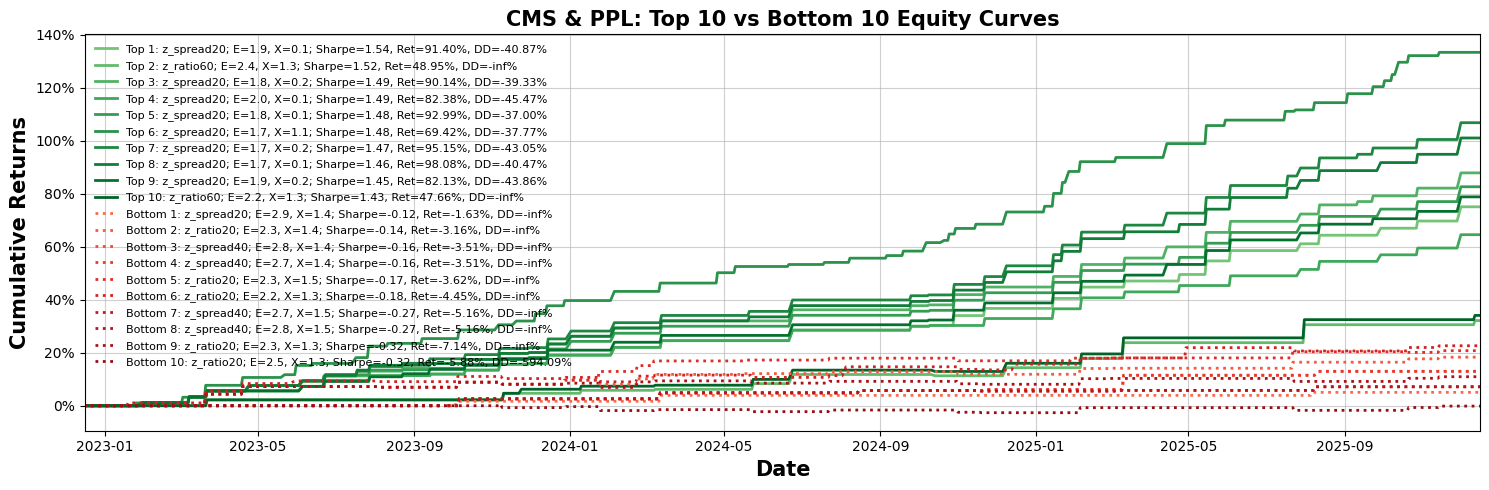

,entry_threshold,exit_threshold,z_score,sharpe_ratio,final_return,max_drawdown
300,1.9,0.1,pos_z_spread20,1.5404,0.9140,-0.4087
1175,2.4,1.3,pos_z_ratio60,1.5185,0.4895,-inf
160,1.8,0.2,pos_z_spread20,1.4906,0.9014,-0.3933
450,2.0,0.1,pos_z_spread20,1.4856,0.8238,-0.4547
150,1.8,0.1,pos_z_spread20,1.4846,0.9299,-0.3700
100,1.7,1.1,pos_z_spread20,1.4821,0.6942,-0.3777
10,1.7,0.2,pos_z_spread20,1.4664,0.9515,-0.4305
0,1.7,0.1,pos_z_spread20,1.4632,0.9808,-0.4047
310,1.9,0.2,pos_z_spread20,1.4511,0.8213,-0.4386
875,2.2,1.3,pos_z_ratio60,1.4288,0.4766,-inf


In [152]:
n = 10
top_n = results_df.head(n)
bottom_n = results_df.tail(n)

fig, ax = plt.subplots(figsize=(15, 5))
for topbottom in ['Top','Bottom']:
    if topbottom == 'Top':
        colors = plt.cm.Greens(np.linspace(0.5, 0.9, n))
        data = top_n
    else:
        colors = plt.cm.Reds(np.linspace(0.5, 0.9, n))
        data = bottom_n
    
    for i, (idx, row) in enumerate(data.iterrows()):
        entry = row['entry_threshold']
        exit_t = row['exit_threshold']
        z_col = row['z_score'].replace('pos_', '')

        pos_df = pairs_trading_simulator(z_pair_df[z_col], entry, exit_t)
        position = pos_df.set_index('Date')['position'].shift(+1).ffill()
        position = position.reindex(df_pair.index, fill_value=0)
        daily_rets = df_pair['spread_daily_log'] * position
        cum_rets = daily_rets.cumsum().apply(np.exp) - 1
        
        label = f"{topbottom.capitalize()} {i+1}: {z_col}; E={entry}, X={exit_t}; Sharpe={row['sharpe_ratio']:.2f}, Ret={row['final_return']:.2%}, DD={row['max_drawdown']:.2%}"
        ax.plot(cum_rets, linewidth=2, label=label, color=colors[i], linestyle='-' if topbottom=='Top' else ':')  

ax.set_xlim(left=coint_window, right=px_df.index.max())
ax.set_title(f'{pair[0]} & {pair[1]}: Top {n} vs Bottom {n} Equity Curves', fontsize=15, fontweight='bold')
ax.set_ylabel('Cumulative Returns', fontsize= 15, fontweight='bold')
ax.set_xlabel('Date', fontsize= 15, fontweight='bold')
ax.legend(loc='upper left', fontsize= 8, framealpha=0)
ax.grid(True, alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()
pd.concat([top_n, bottom_n])

#### Top vs. Bottom Strategy Comparison: Equity Curve Visualization

**Objective:** Compare equity curves of top-performing vs. bottom-performing parameter combinations to visualize strategy robustness and identify performance divergence patterns across optimal and suboptimal threshold settings.

**Steps:**
- Define visualization sample size (n=10); extract top 10 results (highest Sharpe ratios) and bottom 10 results (lowest Sharpe ratios) from sorted results_df for side-by-side comparison.
- Initialize matplotlib figure (15×5) with single axis; create dual-loop structure iterating through 'Top' and 'Bottom' performance groups.
- For each group: assign color palette (green gradient via `plt.cm.Greens()` for top performers, red gradient via `plt.cm.Reds()` for bottom performers) spanning 50%-90% intensity across n=10 strategies.
- For each strategy within group: extract entry/exit thresholds and z-score identifier from results row; call `pairs_trading_simulator()` to regenerate position series with specific thresholds; shift positions forward +1 day and forward-fill to align with trading reality.
- Reindex position series to match df_pair dates (fill missing dates with 0 to handle date misalignment); multiply spread daily log returns by position series to isolate strategy returns; compound via cumsum().apply(np.exp) - 1 for cumulative performance tracking.
- Generate detailed label string containing strategy rank, z-score window, entry/exit thresholds, final Sharpe ratio, cumulative return percentage, and maximum drawdown percentage for legend clarity.
- Plot cumulative returns with individual color from gradient array (`color=colors[i]`), solid line for top performers (`linestyle='-'`), dotted line for bottom performers (`linestyle=':'`), linewidth=2, and alpha transparency for overlay visibility.
- Set x-axis limits from cointegration window start to present (`coint_window` to `px_df.index.max()`) to focus on testing period; add chart title with pair tickers and comparison description; format y-axis as percentage labels; position legend at upper-left with compact font size and transparent background.
- Display combined DataFrame of top_n and bottom_n parameter sets below chart for reference; enables identification of threshold regions producing consistent outperformance vs. systematic underperformance.

**Result:** Dual-overlay equity curve chart with 20 strategies (10 green top performers + 10 red bottom performers); visual separation reveals parameter robustness (tight clustering of top curves vs. divergent bottom curves); legend provides complete strategy specification for each curve; consolidated results table enables quick lookup of optimal vs. failed parameter combinations; confirms mean-reversion strategy viability when properly calibrated while exposing sensitivity to threshold selection.

Testing 10 Utilities pairs across 14 × 15 = 210 parameter combinations...

Pair 1/10: CMS & PPL

Pair 2/10: DTE & DUK


/home/laurent-bernut/Dropbox/Python/Code/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/laurent-bernut/Dropbox/Python/Code/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



Pair 3/10: ^GSPC & CEG

Pair 4/10: CMS & DTE

Pair 5/10: CMS & DUK

Pair 6/10: DTE & PPL

Pair 7/10: CEG & NRG

Pair 8/10: CNP & WEC

Pair 9/10: PPL & VST


/home/laurent-bernut/Dropbox/Python/Code/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/laurent-bernut/Dropbox/Python/Code/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



Pair 10/10: ATO & NI


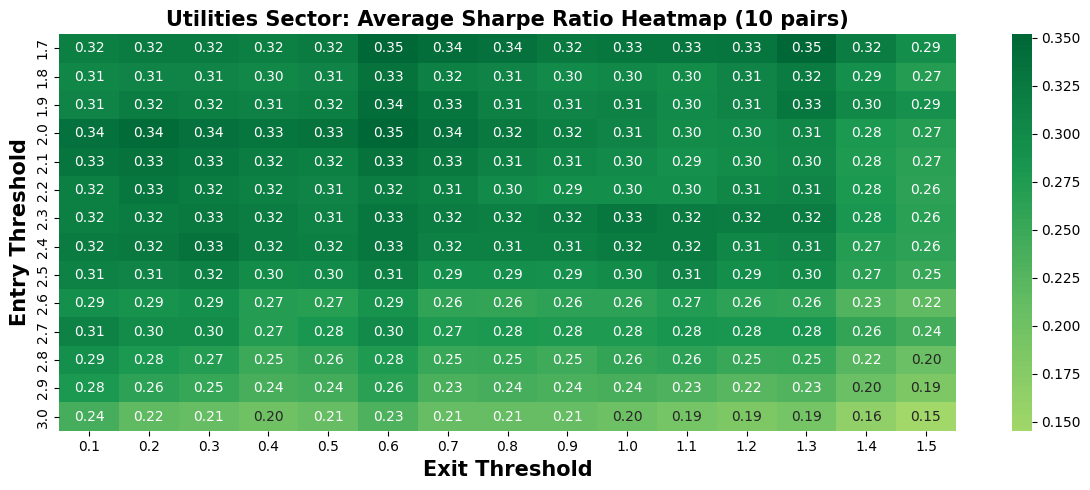


Top 20 parameter combinations (averaged across 10 pairs):


,entry_threshold,exit_threshold,z_score,sharpe_ratio,final_return,max_drawdown
614,2.1,0.2,pos_z_ratio80,0.5875,6.9134,-inf
930,2.3,0.4,pos_z_ratio100,0.5806,4.0809,-inf
900,2.3,0.1,pos_z_ratio100,0.5733,2.8612,-inf
920,2.3,0.3,pos_z_ratio100,0.5647,3.9266,-inf
270,1.8,1.3,pos_z_ratio100,0.5605,2.9511,-inf
970,2.3,0.8,pos_z_ratio100,0.5600,3.9991,-inf
180,1.8,0.4,pos_z_ratio100,0.5575,9.2884,-inf
1573,2.7,0.8,pos_z_ratio60,0.5575,0.6584,-inf
1553,2.7,0.6,pos_z_ratio60,0.5569,1.0585,-inf
600,2.1,0.1,pos_z_ratio100,0.5564,3.7671,-inf


In [ ]:
# Test all parameter combinations across all Utilities sector pairs
entry_thresholds = np.arange(1.7, 3.1, 0.1)
exit_thresholds = np.arange(0.1, 1.6, 0.1)
utilities_results_list = []

# Get all Utilities pairs
utilities_pairs = utilities_pairs_df.index.tolist()
print(f"Testing {len(utilities_pairs)} Utilities pairs across {len(entry_thresholds)} × {len(exit_thresholds)} = {len(entry_thresholds) * len(exit_thresholds)} parameter combinations...")

for pair_idx, pair in enumerate(utilities_pairs):
    print(f"\n{pair_idx + 1}/{len(utilities_pairs)}: {pair[0]}&{pair[1]}", end = '; ')
    
    # Extract z-scores for this pair
    z_pair_dict = {f'{z}': z_df_dict[z][pair] for z in z_df_dict if pair in z_df_dict[z].columns}
    z_pair_df = pd.concat(z_pair_dict, axis=1)
    z_score_cols = [col for col in z_pair_df.columns if col.startswith('z_')]
    
    # Construct spread for this pair
    df_pair = px_df[[pair[0], pair[1]]].ffill().copy()
    df_pair['spread'] = round(df_pair[pair[0]] - df_pair[pair[1]], 5)
    df_pair['spread_daily_log'] = np.log(df_pair['spread'] / df_pair['spread'].shift()).round(5)
    
    # Test all threshold combinations
    for entry_threshold in entry_thresholds:
        for exit_threshold in exit_thresholds:
            z_pair_df_temp = z_pair_df[z_score_cols].copy()
            pos_list_temp = []
            
            for z in z_score_cols:
                pos_df = pairs_trading_simulator(z_pair_df_temp[z], entry_threshold, exit_threshold)
                z_pair_df_temp = pd.concat([z_pair_df_temp, pos_df.set_index('Date')], axis=1)
                z_pair_df_temp.rename(columns={'position': f'pos_{z}'}, inplace=True)
                pos_list_temp += [f'pos_{z}']
            
            z_pair_df_temp = z_pair_df_temp.loc[:, ~z_pair_df_temp.columns.duplicated(keep='last')]
            z_pair_df_temp[pos_list_temp] = z_pair_df_temp[pos_list_temp].shift(+1).ffill()
            
            for pos_col in pos_list_temp:
                df_pair_temp = df_pair.copy()
                position_series = z_pair_df_temp[pos_col].astype(float).fillna(0)
                
                df_pair_temp[f'{pos_col}_daily_log_rets'] = df_pair_temp['spread_daily_log'] * position_series
                df_pair_temp[f'{pos_col}_cum_log_rets'] = df_pair_temp[f'{pos_col}_daily_log_rets'].cumsum()
                df_pair_temp[f'{pos_col}_cumul_returns'] = np.exp(df_pair_temp[f'{pos_col}_cum_log_rets']) - 1
                
                daily_rets = df_pair_temp[f'{pos_col}_daily_log_rets']
                final_return = df_pair_temp[f'{pos_col}_cumul_returns'].iloc[-1]
                max_drawdown = (df_pair_temp[f'{pos_col}_cumul_returns'] / df_pair_temp[f'{pos_col}_cumul_returns'].cummax() - 1).min()
                
                mean_ret = daily_rets.mean()
                std_ret = daily_rets.std()
                sharpe = (mean_ret / std_ret * np.sqrt(252)) if std_ret > 1e-10 else np.nan
                
                utilities_results_list.append({
                    'pair': pair,
                    'entry_threshold': round(entry_threshold, 2),
                    'exit_threshold': round(exit_threshold, 2),
                    'z_score': pos_col,
                    'sharpe_ratio': sharpe,
                    'final_return': final_return,
                    'max_drawdown': max_drawdown
                })

# Convert to DataFrame
utilities_results_df = pd.DataFrame(utilities_results_list)

# Calculate average metrics for each parameter combination
utilities_avg_results = utilities_results_df.groupby(['entry_threshold', 'exit_threshold', 'z_score']).agg({
    'sharpe_ratio': 'mean',
    'final_return': 'mean',
    'max_drawdown': 'mean'
}).reset_index().round(4)

utilities_avg_results = utilities_avg_results.sort_values('sharpe_ratio', ascending=False)

# Create heatmap of average Sharpe ratios
pivot_avg_sharpe = utilities_avg_results.groupby(['entry_threshold', 'exit_threshold'])['sharpe_ratio'].mean().reset_index()
pivot_avg_sharpe = pivot_avg_sharpe.pivot_table(values='sharpe_ratio', index='entry_threshold', columns='exit_threshold')

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_avg_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title(f'Utilities Sector: Average Sharpe Ratio Heatmap ({len(utilities_pairs)} pairs)', fontsize=15, fontweight='bold')
plt.ylabel('Entry Threshold', fontsize=15, fontweight='bold')
plt.xlabel('Exit Threshold', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTop 20 parameter combinations (averaged across {len(utilities_pairs)} pairs):")
utilities_avg_results.head(20)

#### Sector-Wide Parameter Optimization: Utilities Pairs Portfolio Testing

**Objective:** Extend optimization from single pair to entire Utilities sector portfolio by testing all entry/exit threshold combinations across all sector pairs, then aggregate results to identify robust parameters with consistent performance across multiple cointegrated relationships.

**Steps:**
- Define threshold ranges (1.7–3.1 entry, 0.1–1.6 exit) creating 210 parameter combinations; extract all Utilities pairs from utilities_pairs_df for sector-wide testing.
- For each pair: retrieve multi-timeframe z-scores from z_df_dict (10 z-score series per pair); construct spread DataFrame with prices and daily log returns for performance calculation.
- Triple-nested loop structure: iterate through all pairs × all entry thresholds × all exit thresholds × all z-score windows; call `pairs_trading_simulator()` to generate position series for each combination.
- For each position series: multiply spread log returns by positions; compute cumulative returns, Sharpe ratio (mean/std × √252), final return, and maximum drawdown; append results with pair identifier, thresholds, z-score window, and performance metrics to utilities_results_list.
- Aggregate results across pairs: group by entry/exit/z-score and calculate mean Sharpe, mean return, mean drawdown across all pairs to identify parameters with consistent sector-wide performance; sort by average Sharpe descending.
- Create pivot table of average Sharpe ratios by entry/exit thresholds (averaged across all z-score windows and pairs); visualize as heatmap with green for positive Sharpe, red for negative, annotated with values.
- Display top 20 parameter combinations ranked by average Sharpe ratio across entire Utilities sector portfolio.

**Result:** utilities_results_df with thousands of individual pair-parameter-z-score combinations; utilities_avg_results with 210 aggregated parameter sets ranked by sector-wide average Sharpe; heatmap revealing optimal threshold zones (e.g., high entry/low exit) with consistent positive performance across Utilities pairs; enables parameter selection robust to individual pair idiosyncrasies and suitable for multi-pair portfolio deployment.

In [161]:
# Calculate average Sharpe, return, and drawdown for each parameter combination across all pairs
utilities_param_avg = utilities_results_df.groupby(['z_score', 'entry_threshold', 'exit_threshold']).agg({
    'sharpe_ratio': 'mean',
    'final_return': 'mean',
    'max_drawdown': 'mean'
}).round(4).sort_values('sharpe_ratio', ascending=False)

pd.concat([utilities_param_avg.head(), utilities_param_avg.tail()])

sharpe_ratio  final_return  \
z_score        entry_threshold exit_threshold                               
pos_z_ratio80  2.1             0.2                   0.5875        6.9134   
pos_z_ratio100 2.3             0.4                   0.5806        4.0809   
                               0.1                   0.5733        2.8612   
                               0.3                   0.5647        3.9266   
               1.8             1.3                   0.5605        2.9511   
pos_z_ratio20  1.7             1.5                  -0.0730        0.0037   
pos_z_spread40 3.0             0.1                  -0.0829        1.7457   
                               0.4                  -0.0865        0.9924   
pos_z_ratio20  1.8             1.5                  -0.0893       -0.0171   
pos_z_spread40 3.0             0.2                  -0.0907        1.0114   

                                               max_drawdown  
z_score        entry_threshold exit_threshold                
pos_z_ratio80  2.1             0.2                     -inf  
pos_z_ratio100 2.3             0.4                     -inf  
                               0.1                     -inf  
                               0.3                     -inf  
               1.8             1.3                     -inf  
pos_z_ratio20  1.7             1.5                     -inf  
pos_z_spread40 3.0             0.1                     -inf  
                               0.4                     -inf  
pos_z_ratio20  1.8             1.5                     -inf  
pos_z_spread40 3.0             0.2                     -inf

#### Z-Score Window Performance Analysis: Best/Worst Parameter Identification by Timeframe

**Objective:** Re-aggregate sector results by z-score window (instead of by entry/exit) to identify which timeframe windows consistently produce best/worst performance, enabling optimal z-score selection for strategy deployment.

**Steps:**
- Group utilities_results_df by z-score window, entry threshold, and exit threshold (different grouping order prioritizes z-score window analysis); aggregate mean Sharpe, mean return, mean drawdown across all pairs.
- Sort by average Sharpe ratio descending to rank parameter combinations from best to worst performers; round to 4 decimals for readability.
- Concatenate top 5 and bottom 5 parameter combinations to display best-performing vs. worst-performing z-score/threshold combinations side-by-side.
- Analysis reveals whether specific z-score windows (e.g., z_spread20 vs. z_ratio100) systematically outperform others across different threshold settings.

**Result:** Alternative view of utilities_param_avg ranked by z-score window priority; enables identification of optimal z-score representations (spread vs. ratio, short vs. long windows) independent of threshold selection; head/tail comparison shows performance range across timeframe choices.